### **多 GPU 训练**

### **从零开始**

In [14]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

**简单网络**

In [15]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]


def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat


loss = nn.CrossEntropyLoss(reduction="none")

**向多个设备分发参数**

In [16]:
def get_params(params, device):
    # 创建一个新的参数副本列表，将每个参数从原始设备移动到指定的设备上
    new_params = [p.clone().to(device) for p in params]

    # 将新的参数副本列表中的每个参数设置为需要计算梯度
    for p in new_params:
        p.requires_grad_()

    # 返回移动到指定设备并设置了梯度属性的新参数副本列表
    return new_params


new_params = get_params(params, d2l.try_gpu(0))
print("b1 weight:", new_params[1])
print("b1 grad:", new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


**`allreduce` 函数将所有向量相加，并将结果广播给所有 GPU**

In [17]:
def allreduce(data):
    # 将所有数据分片的值累加到第一个数据分片上
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)

    # 将第一个数据分片的值广播到所有其他数据分片上，保持数据一致性
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)


data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print("before allreduce:\n", data[0], "\n", data[1])
allreduce(data)
print("after allreduce:\n", data[0], "\n", data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


**将一个小批量数据均匀地分布在多个 GPU 上**

In [18]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device("cuda:0"), torch.device("cuda:1")]
split = nn.parallel.scatter(data, devices)
print("input :", data)
print("load into", devices)
print("output:", split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [19]:
def split_batch(X, y, devices):
    """将 `X` 和 `y` 拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]  # 确保样本数量匹配

    # 使用 nn.parallel.scatter 将输入数据 X 拆分到多个设备上，并返回数据分片列表
    X_shards = nn.parallel.scatter(X, devices)

    # 使用 nn.parallel.scatter 将标签数据 y 拆分到多个设备上，并返回标签分片列表
    y_shards = nn.parallel.scatter(y, devices)

    # 返回数据分片列表 X_shards 和 y_shards
    return X_shards, y_shards

**在一个小批量上实现多 GPU 训练**

In [20]:
def train_batch(X, y, device_params, devices, lr):
    # 将输入数据 X 和标签 y 拆分到多个设备上的数据分片
    X_shards, y_shards = split_batch(X, y, devices)

    # 计算每个设备上的损失并累加到列表 ls 中
    ls = [
        loss(lenet(X_shard, device_W), y_shard).sum()
        for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)
    ]

    # 对每个损失项执行反向传播
    for l in ls:
        l.backward()

    # 在不计算梯度的情况下同步梯度并更新参数
    with torch.no_grad():
        for i in range(len(device_params[0])):
            # 使用 allreduce 函数同步梯度
            allreduce([device_params[c][i].grad for c in range(len(devices))])

    # 使用随机梯度下降算法在每个设备上更新参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])  # 在一个设备上更新参数

**定义训练函数**

In [21]:
def train(num_gpus, batch_size, lr):
    # 加载 Fashion MNIST 数据集
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    # 创建 GPU 设备列表
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]

    # 为每个设备创建模型参数副本
    device_params = [get_params(params, d) for d in devices]

    # 设置训练的总轮数
    num_epochs = 10

    # 创建动画对象以可视化测试准确率
    animator = d2l.Animator("epoch", "test acc", xlim=[1, num_epochs])

    # 创建计时器对象以测量训练时间
    timer = d2l.Timer()

    # 开始训练迭代
    for epoch in range(num_epochs):
        # 记录当前轮次的开始时间
        timer.start()

        # 遍历训练数据集的每个批次
        for X, y in train_iter:
            # 在多个设备上进行批量训练，同步参数，更新参数
            train_batch(X, y, device_params, devices, lr)

            # 同步所有GPU的操作，确保计时器的精确性
            torch.cuda.synchronize()

        # 记录当前轮次的结束时间
        timer.stop()

        # 计算并记录测试准确率，添加到动画中以进行可视化
        animator.add(
            epoch + 1,
            (
                d2l.evaluate_accuracy_gpu(
                    lambda x: lenet(x, device_params[0]), test_iter, devices[0]
                ),
            ),
        )

    # 打印最终的测试准确率、平均每轮时间和使用的设备列表
    print(
        f"test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch "
        f"on {str(devices)}"
    )

**在单个GPU上运行**

test acc: 0.81, 1.2 sec/epoch on [device(type='cuda', index=0)]


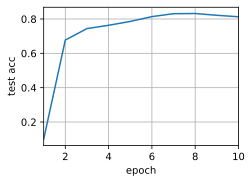

In [31]:
train(num_gpus=1, batch_size=256, lr=0.2)

**增加为2个GPU**

test acc: 0.82, 2.0 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


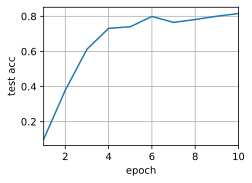

In [32]:
train(num_gpus=2, batch_size=256, lr=0.2)

test acc: 0.76, 1.3 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


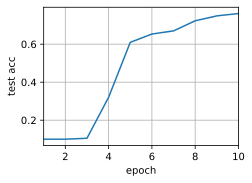

In [33]:
train(num_gpus=2, batch_size=256 * 2, lr=0.2)

test acc: 0.78, 1.3 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


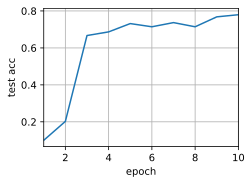

In [25]:
train(num_gpus=2, batch_size=256 * 2, lr=0.2 * 2)

test acc: 0.80, 1.3 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


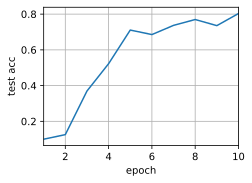

In [26]:
train(num_gpus=2, batch_size=256 * 2, lr=0.2 * 1.5)

--------------------------------------------
### **多GPU的简洁实现**

In [34]:
import torch
from torch import nn
from d2l import torch as d2l

**简单网络**

In [48]:
def resnet18(num_classes, in_channels=1):
    """稍加修改的 ResNet-18 模型"""

    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(
                    d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2)
                )
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        resnet_block(64, 64, 2, first_block=True),
        resnet_block(64, 128, 2),
        resnet_block(128, 256, 2),
        resnet_block(256, 512, 2),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes),
    )
    return net

net = resnet18(10)

**训练**

In [51]:
def train(net, num_gpus, batch_size, lr):
    # 加载 Fashion MNIST 数据集
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    
    # 创建 GPU 设备列表
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    
    # 初始化模型权重的函数，应用于网络的每个参数
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    
    # 对网络应用初始化权重函数，初始化网络的参数
    net.apply(init_weights)
    
    # 使用 DataParallel 将网络复制到多个 GPU 上
    net = nn.DataParallel(net, device_ids=devices)
    
    # 创建优化器，使用随机梯度下降算法
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    
    # 创建损失函数，使用交叉熵损失
    loss = nn.CrossEntropyLoss()
    
    # 创建计时器对象以测量训练时间
    timer, num_epochs = d2l.Timer(), 10
    
    # 创建动画对象以可视化测试准确率
    animator = d2l.Animator("epoch", "test acc", xlim=[1, num_epochs])
    
    # 开始训练迭代
    for epoch in range(num_epochs):
        # 将网络设置为训练模式
        net.train()
        
        # 记录当前轮次的开始时间
        timer.start()
        
        # 遍历训练数据集的每个批次
        for X, y in train_iter:
            # 清空梯度
            trainer.zero_grad()
            
            # 将输入数据 X 和标签 y 移动到第一个 GPU 上
            X, y = X.to(devices[0]), y.to(devices[0])
            
            # 计算损失并进行反向传播
            l = loss(net(X), y).sum()
            l.backward()
            
            # 更新参数
            trainer.step()
        
        # 记录当前轮次的结束时间
        timer.stop()
        
        # 计算并记录测试准确率，添加到动画中以进行可视化
        animator.add(
            epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter, devices[0]),)
        )
    
    # 打印最终的测试准确率、平均每轮时间和使用的设备列表
    print(
        f"test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch "
        f"on {str(devices)}"
    )


**在单个GPU上训练网络**

test acc: 0.91, 2.8 sec/epoch on [device(type='cuda', index=0)]


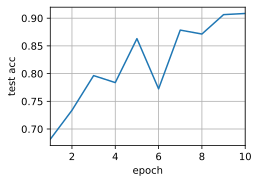

In [52]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

**使用 2 个 GPU 训练**

test acc: 0.90, 5.2 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


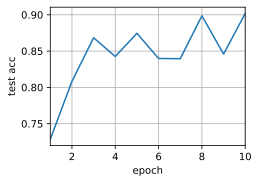

In [53]:
train(net, num_gpus=2, batch_size=256, lr=0.1)

test acc: 0.76, 3.0 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


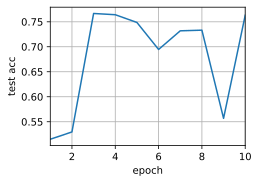

In [54]:
train(net, num_gpus=2, batch_size=256*2, lr=0.1*2)

-------------------------------------------
### **QA**
- 多GPU训练的时候，速度没有变快，是什么原因？
  1. **数据传输开销：** 在多GPU训练中，数据需要在不同GPU之间进行传输。如果数据传输开销大于模型计算时间，那么多GPU并行可能不会带来明显的加速效果。
  2. **小规模模型：** 对于小规模模型，模型计算本身可能很快完成，而数据传输和同步开销却可能变得相对较大，导致多GPU训练的加速效果有限。
  3. **单一GPU瓶颈：** 如果模型中有某些部分是在单个GPU上运行的（例如，模型的某些层只能在单个GPU上计算），那么这些部分可能会成为整体训练速度的瓶颈。
  4. **未优化的并行策略：** 并行训练需要适当的数据分布、同步策略和优化算法，否则可能会导致性能问题。不正确的并行策略可能会阻碍模型的训练。
  5. **内存限制：** 如果每个GPU的内存不足以容纳完整的模型和批量数据，可能需要更小的批次大小，这可能会降低训练速度。
  6. **模型架构：** 某些模型架构不适合多GPU训练，或者需要进行特定的优化才能获得良好的并行性能。
  7. **优化问题：** 一些训练过程可能需要调整学习率、权重初始化和正则化等超参数，以便在多GPU环境下获得最佳的收敛性能。
  8. **硬件配置：** 多GPU训练的效果也受到硬件配置的影响，包括GPU类型、连接方式和计算能力等。

--------------------------------------
- 数据并行时，每个GPU会得到所有的参数